# Homework 8: Generalizations of linear models.

*Instructions:*
Please answer the following questions and submit your work
by editing this jupyter notebook and submitting it on Canvas.
Questions may involve math, programming, or neither,
but you should make sure to *explain your work*:
i.e., you should usually have a cell with at least a few sentences
explaining what you are doing.

Also, please be sure to always specify units of any quantities that have units,
and label axes of plots (again, with units when appropriate).

In [36]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(123)
from scipy.optimize import minimize
from scipy.stats import nbinom
from sklearn.linear_model import LogisticRegression

# 1. Logistic exposure

Suppose that the probability that someone comes down with the flu
depends on two things:
- the amount of exposure to others with an active case of the flu
    (measured in units of person-minutes), and
- how well their antibodies attach to the flu circulating that year
    (measured in units of "binding antibody units" (BAU) per mL).

**(a)** Suppose that the probability that someone with total exposure $E$ person-minutes
    and antibody binding $B$ BAU/mL is
    $$  p(E, B) = \frac{1}{1 + e^{-(a E + b B + c)}}, $$
    with $a=1/100$, $b=-1/300$, and $c=-3$.
    Write a function that, given arrays of the same length of $E$ and $B$ values,
    returns (i.e., simulates) an array of 0's and 1's, one for each $E, B$ pair,
    so that the $i^\text{th}$ entry is 1 with probability $p(E_i, B_i)$.
    (A "1" in the $i^\text{th}$ entry will indicate that the $i^\text{th}$ person caught the flu.)
    
**(b)** Create one simulated dataset using your function with the following values of $E$ and $B$:

In [37]:
E = np.array([136, 537, 447, 176, 218, 283, 513, 466, 603, 219,  44, 606, 410,
        536, 336, 212, 521, 211, 433, 464, 404, 575, 171, 257, 843, 272,
        271, 196, 149, 304, 187, 218,  94, 345, 318, 234, 455, 653, 193,
        288, 178, 635, 174, 135, 342, 523, 353, 544, 220, 426, 191, 221,
        223, 230, 432, 563, 210, 174, 223, 176, 417, 227, 310, 321, 310,
        220, 571, 658, 279, 518, 235, 328, 175, 464, 612, 242, 185, 352,
        212, 335, 276, 234, 249, 421, 358, 300, 167, 209, 492, 584, 765,
        277, 162, 156, 217, 599, 399, 144, 292, 125])
B = np.array([ 330,  581, 1381, 2013, 1144, 1571, 1151, 1293,  983, 1101,  279,
         714, 1880,  676,  464, 1514,  117,  584, 1015,  420,  202, 1605,
        1540,  989,  962, 1407, 1333,  675,  300,  379,  711,  925, 1219,
         490,  702, 1086,  950, 1126,  263,  713, 1343,  309,  630, 1074,
        1305, 1468,  970, 1422,  754,  508,  872, 1137, 1648, 1217, 1731,
        1077, 1353,  742,  331, 1263,  962, 1116,  248,  971, 1929,  261,
        1367,  779, 1814,  295,  594,  421,  671, 1408, 1076, 1613, 2142,
        1127,  596,  813,  497, 1219, 2021, 1546,  558,  884,  307,  778,
         378, 1473,  386, 1162,  365,  387, 2805, 1058, 1367, 1822, 1194,
        1307])

**(c)** Fit a logistic model to the data,
    inferring the values of $a$, $b$ and $c$.
    Make a plot or otherwise depict the predicted chance of getting the flu
    using these estimated parameters
    as a function of exposure, both at $B=200$ and $B=2000$.
    Compare these curves to the true curves obtained with the parameters used to simulate the data.
    *(You can fit the model with `scikit-learn.linear_model.LogisticRegression`, as we did in class,
    or by implementing the likelihood.)*

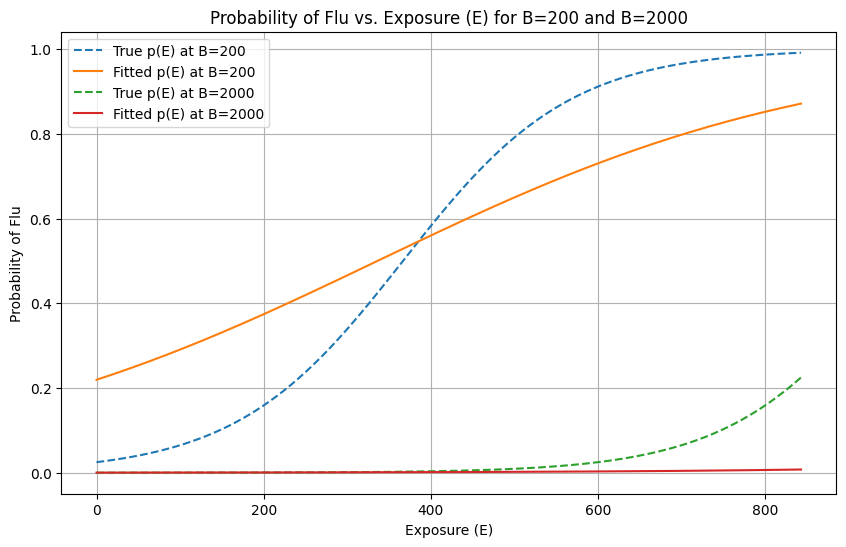

Estimated a: 0.0038, Estimated b: -0.0038, Estimated c: -0.5157


In [38]:
# 1(a) - Define function to simulate flu outcomes
def simulate_flu_outcomes(E, B):
    a = 1/100
    b = -1/300
    c = -3
    linear_term = a * E + b * B + c
    p = 1 / (1 + np.exp(-linear_term))
    outcomes = np.random.binomial(1, p)
    return outcomes, p

# 1(b) - Generate simulated dataset using provided E and B
flu_outcomes, true_probs = simulate_flu_outcomes(E, B)

# 1(c) - Fit logistic regression model and compare curves
X = np.column_stack([E, B])
model = LogisticRegression()
model.fit(X, flu_outcomes)
fitted_a, fitted_b = model.coef_[0]
fitted_c = model.intercept_[0]

# Define function to plot predicted probabilities vs. exposure for B=200 and B=2000
exposure_grid = np.linspace(0, max(E), 200)
B_values = [200, 2000]

plt.figure(figsize=(10,6))
for B_val in B_values:
    true_curve = 1 / (1 + np.exp(-(1/100 * exposure_grid + -1/300 * B_val + -3)))
    fitted_curve = 1 / (1 + np.exp(-(fitted_a * exposure_grid + fitted_b * B_val + fitted_c)))
    plt.plot(exposure_grid, true_curve, '--', label=f"True p(E) at B={B_val}")
    plt.plot(exposure_grid, fitted_curve, '-', label=f"Fitted p(E) at B={B_val}")

plt.xlabel("Exposure (E)")
plt.ylabel("Probability of Flu")
plt.title("Probability of Flu vs. Exposure (E) for B=200 and B=2000")
plt.legend()
plt.grid(True)
plt.show()

print(f"Estimated a: {fitted_a:.4f}, Estimated b: {fitted_b:.4f}, Estimated c: {fitted_c:.4f}")


# 2. Overdispersed mosquitos

Recall the per-kid mosquito bite and odor (in ppm) data from HW#7.
Well, we turned up some more data, from unfortunate kids who were kept home after the trip
due to a large number of mosquito bites.
Here are the new, amended data:

In [39]:
bites = np.array([4, 5, 4, 2, 4, 8, 4, 6, 7, 5, 4, 0, 5, 7, 5, 3, 2, 0, 3, 4, 5, 3, 6, 1, 2, 3, 5,
                  20, 31])  # <-- new
odor = np.array([ 2.8,  4.4,  6.9,  2.3,  5.9, 10.2,  3.2,  7.6,  6.3,  4.5,  4.3,
                0. ,  8.2,  5.4,  7.6,  3.3,  3.9,  0.1,  2.7,  4.7,  2.1,  4.3,
               11.3,  1.7,  2.8,  2.9,  8.5,
                5.2, 9.8])  # <-- new

Previously, we fit a *Poisson* model,
but these data show overdispersion.
Please fit a *Negative Binomial* model: as before,
if $Y_i$ is the number of bites the $i^\text{th}$ kid got,
and $X_i$ is their "odor" value, then we want to fit:
$$\begin{aligned}
    Y_i \sim \text{NegBinom}(\text{mean}= \exp(a X_i + b), \text{n}=n) ,
\end{aligned}$$
i.e., find the values of $a$ and $b$ and $n$ at which this model
best fits the data.
(Another way to parameterize the Negative Binomial distribution,
as used for instance by [scikit-learn](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.nbinom.html#scipy.stats.nbinom) is with $n$ and $p$;
if the mean is $\mu$, then
then these are related by $p = 1/(1 + \mu/n)$.)

*(a)* Implement the negative log-likelihood function:
    this should take $a$ and $b$ and $n$ as arguments,
    and return the negative log likelihood of the data (i.e., of `bites` and `odor`)
    under the model above.
    You may use `scipy.stats.nbinom`.

*(b)* Use your function from (a) and `scipy.optimize.minimize` to find
    the maximum likelihood estimates of $a$ and $b$ and $n$.
    *Note:* you may have to try different starting points to find starting place
    that converges successfully
    (the output should say "Optimization terminated successfully").

*(c)* Showing how expected number of bites (using the MLE values of $a$ and $b$ from (b))
    increases with odor and how this compares to the observed number of bites
    (for instance, by plot of the data with a line for the expected number);
    include a comparison to our previous model
    (which had mean bites = $\exp(1.3 \times \text{odor} + 0.7 )$).

MLE estimates: a = 0.2050, b = 0.5246, n = 3.8990


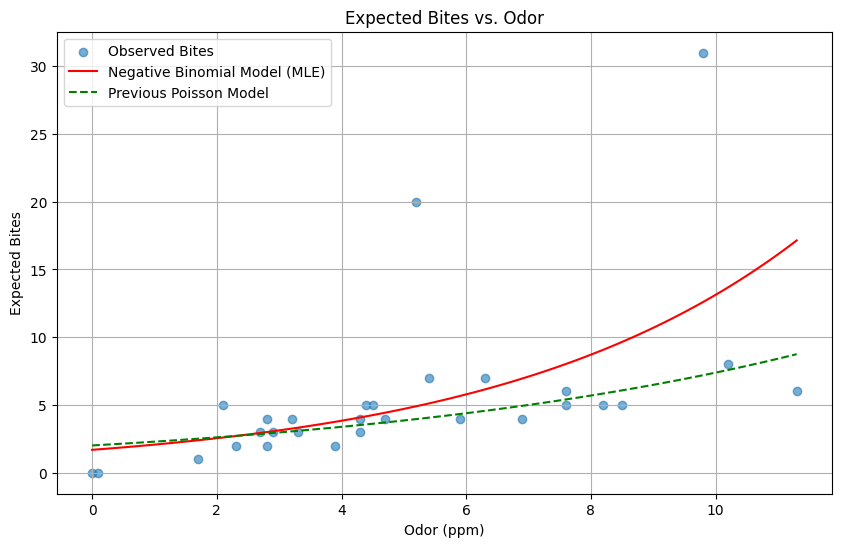

In [40]:
# 2(a) - Negative log-likelihood function for Negative Binomial
def neg_log_likelihood(params, odor, bites):
    a, b, n = params
    mu = np.exp(a * odor + b)
    p = 1 / (1 + mu / n)
    ll = nbinom.logpmf(bites, n, p)
    return -np.sum(ll)

# 2(b) - Fit the Negative Binomial model
initial_guess = [0.1, 0.5, 1.0]  # Reasonable starting guess
bounds = [(None, None), (None, None), (1e-5, None)]  # n must be >0

result = minimize(neg_log_likelihood, initial_guess, args=(odor, bites), bounds=bounds)

a_hat, b_hat, n_hat = result.x
print(f"MLE estimates: a = {a_hat:.4f}, b = {b_hat:.4f}, n = {n_hat:.4f}")

# 2(c) - Plot predicted vs. observed bites
odor_grid = np.linspace(min(odor), max(odor), 100)
mu_hat = np.exp(a_hat * odor_grid + b_hat)
mu_prev_model = np.exp(0.13 * odor_grid + 0.7)

plt.figure(figsize=(10,6))
plt.scatter(odor, bites, alpha=0.6, label='Observed Bites')
plt.plot(odor_grid, mu_hat, label='Negative Binomial Model (MLE)', color='r')
plt.plot(odor_grid, mu_prev_model, label='Previous Poisson Model', color='g', linestyle='--')
plt.xlabel("Odor (ppm)")
plt.ylabel("Expected Bites")
plt.title("Expected Bites vs. Odor")
plt.legend()
plt.grid(True)
plt.show()
